In [1]:
# Initial setup and imports
import os
import gc
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enable GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPUs found, using CPU")

print(f"TensorFlow version: {tf.__version__}")


No GPUs found, using CPU
TensorFlow version: 2.19.0


In [2]:
# Configuration - reduced sizes to prevent memory issues
IMG_SIZE = 256  # Reduced from 512 to prevent memory issues
BATCH_SIZE = 4  # Small batch size for memory efficiency
NUM_CLASSES = 4  # 0=Soil, 1=Sand, 2=Bedrock, 3=Big Rock
BUFFER_SIZE = 1000
EPOCHS = 5  # Start with fewer epochs for testing

# Dataset paths
TRAIN_IMG_DIR = "dataset/train/images"
TRAIN_MASK_DIR = "dataset/train/masks"
TEST_IMG_DIR = "dataset/test/images"
TEST_MASK_DIR = "dataset/test/masks"

# Verify dataset existence and count files
for dir_path in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    if os.path.exists(dir_path):
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{dir_path}: {count} files")
    else:
        print(f"ERROR: {dir_path} does not exist!")

# Define color map for visualization
colormap = {
    0: (139, 69, 19),    # Brown (Soil)
    1: (255, 255, 0),    # Yellow (Sand)
    2: (128, 128, 128),  # Gray (Bedrock)
    3: (255, 0, 0),      # Red (Big Rock)
}


dataset/train/images: 12851 files
dataset/train/masks: 12851 files
dataset/test/images: 3213 files
dataset/test/masks: 3213 files


In [3]:
# CRITICAL FIX: Preprocessing function that handles mask values of 255
def preprocess_image(image_path, mask_path):
    """Memory-efficient preprocessing function using TensorFlow ops"""
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    
    # CRITICAL: Remap 255 values to 0 (valid class index)
    # This fixes the "label value of 255 outside valid range [0, 4)" error
    mask = tf.where(mask == 255, 0, mask)
    
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask[..., tf.newaxis], [IMG_SIZE, IMG_SIZE], method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    
    return image, mask

def create_dataset(image_dir, mask_dir, is_training=True):
    """Create tf.data.Dataset with efficient preprocessing"""
    # Get file paths
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
    mask_files = [f.replace('.JPG', '.png').replace('.jpg', '.png') for f in image_files]
    
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_files]
    
    # Verify files exist
    valid_pairs = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append((img_path, mask_path))
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs in {image_dir}")
    
    image_paths, mask_paths = zip(*valid_pairs)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(mask_paths)))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(BUFFER_SIZE)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [4]:
# Create datasets and test data loading
print("Creating training dataset...")
train_dataset = create_dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, is_training=True)

print("Creating test dataset...")
test_dataset = create_dataset(TEST_IMG_DIR, TEST_MASK_DIR, is_training=False)

# Calculate dataset sizes
train_size = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])
test_size = len([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE

print(f"Training samples: {train_size}, Steps per epoch: {steps_per_epoch}")
print(f"Test samples: {test_size}, Validation steps: {validation_steps}")

# Test data loading and verify mask values are now in valid range
print("\nTesting data loading...")
for batch_images, batch_masks in train_dataset.take(1):
    print(f"Batch shape - Images: {batch_images.shape}, Masks: {batch_masks.shape}")
    print(f"Image dtype: {batch_images.dtype}, range: [{tf.reduce_min(batch_images):.3f}, {tf.reduce_max(batch_images):.3f}]")
    print(f"Mask dtype: {batch_masks.dtype}, range: [{tf.reduce_min(batch_masks)}, {tf.reduce_max(batch_masks)}]")
    
    # Check unique mask values to ensure 255 is remapped
    unique_values = tf.unique(tf.reshape(batch_masks, [-1]))[0]
    print(f"Unique mask values in batch: {unique_values.numpy()}")
    
    if tf.reduce_max(batch_masks) >= NUM_CLASSES:
        print("ERROR: Mask values still outside valid range!")
    else:
        print("✓ All mask values are now in valid range [0, 3]")

# Clean up memory
gc.collect()
print("\nData loading test completed successfully!")


Creating training dataset...
Found 12851 valid image-mask pairs in dataset/train/images
Creating test dataset...
Found 3213 valid image-mask pairs in dataset/test/images
Training samples: 12851, Steps per epoch: 3212
Test samples: 3213, Validation steps: 803

Testing data loading...
Batch shape - Images: (4, 256, 256, 3), Masks: (4, 256, 256)
Image dtype: <dtype: 'float32'>, range: [0.008, 1.000]
Mask dtype: <dtype: 'int32'>, range: [0, 3]
Unique mask values in batch: [0 1 2 3]
✓ All mask values are now in valid range [0, 3]

Data loading test completed successfully!


2025-08-04 22:01:06.997852: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
import tensorflow as tf

def segnet(input_shape=(256, 256, 3), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    # Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)


In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K


def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    # assume y_true and y_pred are both (batch_size, height, width, num_classes)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1,2])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1,2])

    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=-1)
    return 1 - tf.reduce_mean(dice)



In [7]:
model= segnet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
# Start training with error handling
print("Starting training...")
print("=" * 50)

try:
    history = model.fit(
        train_dataset,
        epochs=15,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_dataset,
        validation_steps=validation_steps,
        verbose=1
    )
    
    print("\n🎉 Training completed successfully!")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\nTroubleshooting suggestions:")
    print("1. Reduce BATCH_SIZE further (try 2 or 1)")
    print("2. Reduce IMG_SIZE further (try 128)")
    print("3. Check GPU memory: nvidia-smi")
    print("4. Restart kernel to clear memory")
    raise e


Starting training...
Epoch 1/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 3748s 1s/step - accuracy: 0.6478 - loss: 0.8404 - val_accuracy: 0.6510 - val_loss: 0.8428
Epoch 2/15
   1/3212 ━━━━━━━━━━━━━━━━━━━━ 43:04 805ms/step - accuracy: 0.6186 - loss: 0.8728

/Users/yatharthvardan/Documents/USD/ai4mars-dataset-merged-0.1/py11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3212/3212 ━━━━━━━━━━━━━━━━━━━━ 280s 87ms/step - accuracy: 0.6186 - loss: 0.8728 - val_accuracy: 0.6510 - val_loss: 0.8433
Epoch 3/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 3758s 1s/step - accuracy: 0.6460 - loss: 0.8428 - val_accuracy: 0.6510 - val_loss: 0.8418
Epoch 4/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 279s 87ms/step - accuracy: 0.3262 - loss: 1.1730 - val_accuracy: 0.6510 - val_loss: 0.8421
Epoch 5/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 3710s 1s/step - accuracy: 0.6443 - loss: 0.8447 - val_accuracy: 0.6510 - val_loss: 0.8404
Epoch 6/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 281s 87ms/step - accuracy: 0.6031 - loss: 0.7768 - val_accuracy: 0.6510 - val_loss: 0.8404
Epoch 7/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 3715s 1s/step - accuracy: 0.6468 - loss: 0.8450 - val_accuracy: 0.6510 - val_loss: 0.8333
Epoch 8/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 289s 90ms/step - accuracy: 0.4790 - loss: 0.9390 - val_accuracy: 0.6510 - val_loss: 0.8332
Epoch 9/15
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 3727s 1s/step - accuracy: 0.6441 - loss: 

In [10]:
model.save('segnet_model.keras')

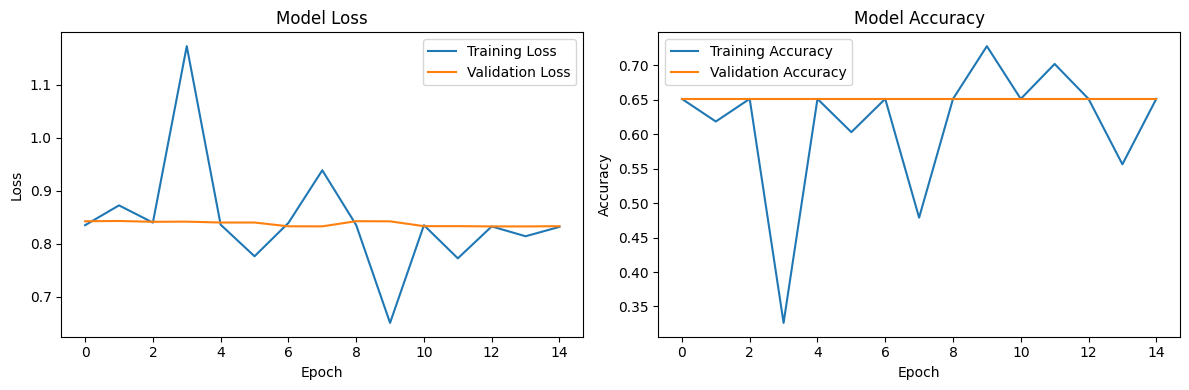

Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


2025-08-05 11:33:23.684545: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


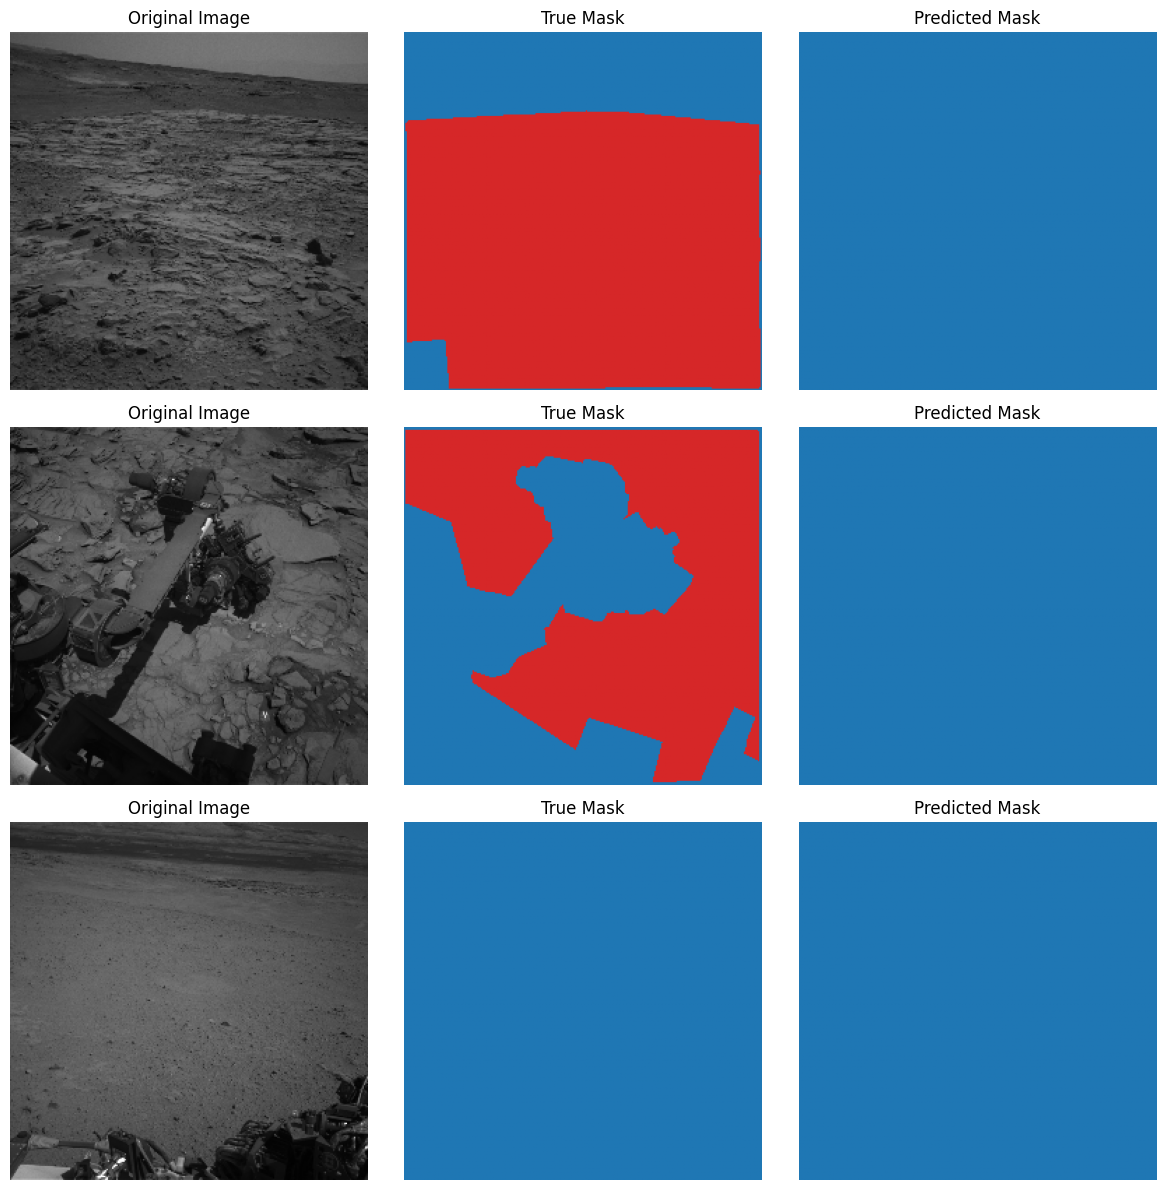

In [11]:
# Visualization and results
def visualize_sample_predictions(model, dataset, num_samples=3):
    """Visualize sample predictions"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Take first image from batch
        image = images[0]
        true_mask = masks[0]
        
        # Predict
        pred_mask = model.predict(tf.expand_dims(image, 0))[0]
        pred_mask = tf.argmax(pred_mask, axis=-1)
        
        # Plot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history if training succeeded
if 'history' in locals():
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show sample predictions
    print("Sample predictions:")
    visualize_sample_predictions(model, test_dataset)



In [14]:
print(f"Accuracy of the SegNet Image segmentation model is {history.history['accuracy'][-1]}")
print(f"Loss of the SegNet Image segmentation model is {history.history['loss'][-1]}")
print(f"Validation Accuracy of the SegNet Image segmentation model is {history.history['val_accuracy'][-1]}")
print(f"Validation Loss of the SegNet Image segmentation model is {history.history['val_loss'][-1]}")
print(f"Epochs of the SegNet Image segmentation model is {history.epoch[-1]}")

Accuracy of the SegNet Image segmentation model is 0.6514809727668762
Loss of the SegNet Image segmentation model is 0.8322311043739319
Validation Accuracy of the SegNet Image segmentation model is 0.6509730815887451
Validation Loss of the SegNet Image segmentation model is 0.8334864974021912
Epochs of the SegNet Image segmentation model is 14


In [15]:
import numpy as np

def compute_class_iou(y_true, y_pred, num_classes):
    iou_per_class = {}
    
    for class_id in range(2):
        # Create binary masks for current class
        true_class = (y_true == class_id)
        pred_class = (y_pred == class_id)
        
        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()
        
        iou = intersection / union if union != 0 else 0.0
        iou_per_class[f"class_{class_id}"] = round(iou, 4)
    
    mean_iou = round(np.mean(list(iou_per_class.values())), 4)
    return iou_per_class, mean_iou


In [16]:
# Assuming your model outputs softmax over classes:
MEAN_IOU = []

for i, (image, mask) in enumerate(test_dataset):
    image = image[0]
    true_mask = mask[0]
        
    # Predict
    pred_mask = model.predict(tf.expand_dims(image, 0))[0]
    pred_mask = tf.argmax(pred_mask, axis=-1)        # shape: (H, W)
    
    true_class_mask = true_mask.numpy().squeeze()              # shape: (H, W), same format
    num_classes = pred_mask.shape[-1]
    per_class_iou, mean_iou = compute_class_iou(true_class_mask, pred_mask, num_classes)
    MEAN_IOU.append(mean_iou)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━

In [17]:
print(f"Mean IOU of the model is {np.mean(MEAN_IOU)}")

Mean IOU of the model is 0.320853855721393
